## Naive Bayes (bayesiano)
---
Na abordagem (ainda mais) bayesiana do Naive Bayes, assume uma distribuição a priori para os atributos dos dados. Neste trabalho, como os atributos são binários, iremos utilizar as seguintes prioris conjugadas:

$$ p(\pi) = Dir(\pi|\alpha) $$
$$ p(\theta_{dc}) = Beta(\theta_{dc} | a,b) $$

In [1]:
import pandas as pd
import numpy as np
from scipy.special import gamma
from scipy.stats import dirichlet
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
%matplotlib inline

In [2]:
def beta(a,b,q):
    return (gamma(a+b)/(gamma(a)*(gamma(b))))*(q**(a-1))*((1-q)**(b-1))

In [3]:
df = pd.read_csv("votesDataset.csv", names=range(0,16), header=None, skiprows=1, index_col=None)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
republican,0,1,0,1,1,1,0,0,0,1,0,1,1,0,0,1
republican,0,1,0,1,1,1,0,0,0,0,0,1,1,0,0,1
democrat,0,1,1,0,1,1,0,0,0,0,1,0,1,0,0,0
democrat,0,1,1,0,1,1,0,0,0,0,1,0,1,0,0,1
democrat,1,1,1,0,1,1,0,0,0,0,1,0,1,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
republican,0,0,1,1,1,1,0,0,1,1,0,1,1,0,0,1
democrat,0,0,1,0,0,0,1,1,1,1,0,0,0,1,0,1
republican,0,0,0,1,1,1,0,0,0,0,1,1,1,0,0,1
republican,0,0,0,1,1,1,1,1,0,1,0,1,1,1,0,1


In [4]:
classes, sizes = np.unique(df.index.values, return_counts=True)
N = np.sum(sizes)
print(f"Total de {N} observações")
for c,s in zip(classes, sizes):
    print(f"Classe {c} com {s} observações")

Total de 435 observações
Classe democrat com 267 observações
Classe republican com 168 observações


In [5]:
n_attr = df.values.shape[1]
print(f"{n_attr} atributos")

16 atributos


Para cada atributo ($\theta_d$) de cada classe ($\theta_{dc}$), definimos uma priori, seguindo uma distribuição beta, onde os valores de *a* e de *b* são 2 mais um ruído. Dessa forma, atribuímos distribuições a priori diferentes para cada atributo. Os valores de *a* e de *b* utilizados são salvos, para cálculos futuros

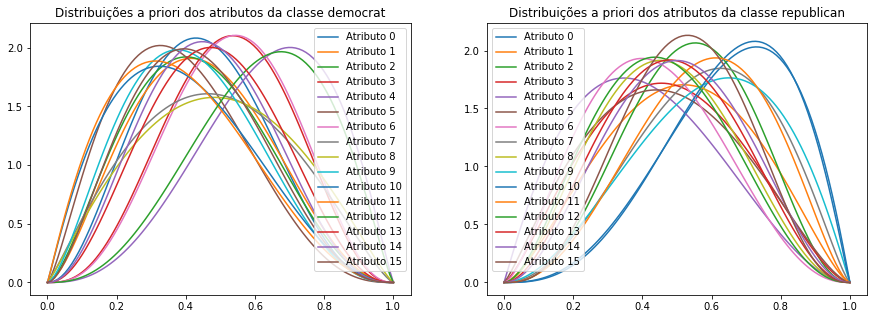

In [12]:
def create_random_hiperparameters(base=2):
    return [base+np.random.rand()*2 for _ in range(n_attr)]
a = np.array([create_random_hiperparameters(2) for _ in classes])
b = np.array([create_random_hiperparameters(2) for _ in classes])

theta = np.linspace(0,1,100)
plt.figure(figsize=(15,5))
prioris = []
for i,c in enumerate(classes):
    plt.subplot(1,len(classes),i+1)
    priori = np.array([beta(a,b, theta) for a,b in zip(a[i,:],b[i,:])])
    for i,line in enumerate(priori):
        plt.plot(theta, line, label=f"Atributo {i}")
    plt.title(f"Distribuições a priori dos atributos da classe {c}")
    plt.legend()
    prioris.append(priori)

Para a distribuição de dirichlet, atribuímos um valor *alpha* de **relevância** para cada classe. No caso, assumimos que, a priori, ambas as classes são igualmente relevantes

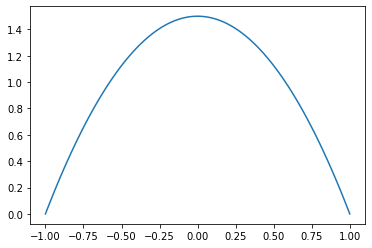

In [7]:
alpha = [2 for _ in classes]
deltaTheta = 1 - 2*theta
pi_class = dirichlet.pdf([theta, 1-theta], alpha)
plt.plot(deltaTheta, pi_class)

Agora que temos as prioris para $\pi$ e $\theta$, vamos encontrar os valores a posteriori. A partir das conjugações das distribuições, as posterioris são calculadas pelas seguintes fórmulas:

$$ \bar{\theta}_{dc} = \frac{N_{dc} + b}{N_c + a + b} $$

$$ \bar{\pi}_c = \frac{N_c + \alpha_c}{N + \sum^C_{c=1} \alpha_c} $$

In [8]:
thetas = []
pis = []
for i,c in enumerate(classes):
    X = df[df.index == c].values
    
    N_c = sizes[i]
    N_dc = np.sum(X, axis = 0)
    
    a_c = a[i,:]
    b_c = b[i,:]
    
    theta_c = (N_dc + b_c)/(N_c + a_c + b_c)
    pi_c = (N_c + alpha[i])/(N + sum(alpha))
    
    thetas.append(theta_c)
    pis.append(pi_c)

Agora que temos os valores a posteriori, para encontrarmos a probabilidade de uma observação pertencer a uma classe $c$, basta calcularmos

$$\bar{\pi}_c \prod^D_{d=1} (\bar{\theta}_{dc})^{\mathcal{I}(x_d = 1)} (1-\bar{\theta}_{dc})^{\mathcal{I}(x_d = 0)}$$

In [9]:
predictions = []
for y,x in list(zip(df.index, df.values)):
    probs = []
    for c,theta,pi in zip(classes, thetas, pis):
        y_c = pi*np.prod((theta ** x) * (1 - theta) ** (1 - x))
        probs.append(y_c)
    predictions.append(classes[np.argmax(probs)])

In [10]:
cm = confusion_matrix(df.index.values, predictions, labels=classes)
cm

array([[237,  30],
       [ 20, 148]])

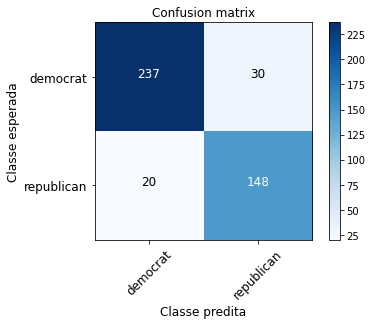

In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = (cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])
        nan_indexes = np.isnan(cm)
        cm[nan_indexes] = 0

    plt.figure()
    plt.rcParams["axes.grid"] = False
    plt.imshow(cm, cmap=cmap)

    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                fontsize=12)

    plt.ylabel('Classe esperada', fontsize=12)
    plt.xlabel('Classe predita', fontsize=12)
    
plot_confusion_matrix(cm, classes, normalize=False)